In [219]:
# Load various imports 
import pandas as pd
import os
import librosa
import librosa.display
from sklearn import preprocessing
import numpy as np
import IPython


In [220]:
path_train = 'data/train_labels.csv'
path_test = 'data/test_files.csv'
num_cc = 100
max_pad_len = 100
df = pd.read_csv(path_train)
df['filename'] = df['filename'].map(lambda x: 'data/data/%04d.wav' % x)
le = preprocessing.LabelEncoder()
df['height'] = le.fit_transform(df['height'])
le = preprocessing.LabelEncoder()
df['pasture'] = le.fit_transform(df['pasture'])
print(len(df.index))
df.head(2)

1532


,filename,pasture,height,label
0,data/data/0004.wav,0,1,2
1,data/data/0009.wav,0,1,2


In [221]:
IPython.display.Audio(df.loc[4]['filename'])

In [290]:

mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=num_cc)
print(mfccs.shape)
stft = np.abs(librosa.stft(audio))
chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
print(chroma.shape)

mel = np.mean(librosa.feature.melspectrogram(audio, sr=sample_rate).T,axis=0)
print(mel.shape)
      
contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
print(contrast.shape)

(100, 35)
(12,)
(128,)
(7,)


In [295]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T,axis=0)

    stft = np.abs(librosa.stft(audio))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    
    mel = np.mean(librosa.feature.melspectrogram(audio, sr=sample_rate).T,axis=0)
    
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    #tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sample_rate).T,axis=0)

    return mfccs,chroma,mel,contrast

In [284]:
def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=num_cc)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccs

In [285]:
def extract_features2(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    audio.reshape((-1, 4))
    return audio

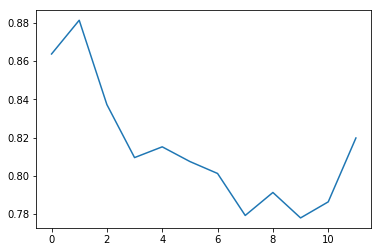

In [286]:
%matplotlib inline
import matplotlib.pyplot as plt

file_name = df.loc[3].filename
audio, sample_rate = librosa.load(file_name, res_type='polyphase') 
stft = np.abs(librosa.stft(audio))
chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
plt.plot(chroma)
plt.show()

In [296]:

features = []
for k,row in df.iterrows():
    class_label = row["label"]
    mfccs,chroma,mel,contrast = extract_features(row['filename'])
    #mfccs,chroma,mel,contrast = extract_features(fn)
    ext_features = np.hstack([mfccs,chroma,mel,contrast])

    features.append([ext_features, class_label])
df_features = pd.DataFrame(features, columns=['feature','class_label'])
print('Finished feature extraction from ', len(df_features), ' files')
df_features['pasture'] = row['pasture']
df_features['height'] = row['height']
df_features.head(2)

Finished feature extraction from  1532  files


,feature,class_label,pasture,height
0,"[-395.9031677246094, 134.2984619140625, 51.110...",2,1,1
1,"[-369.43743896484375, 158.50547790527344, 30.4...",2,1,1


In [298]:
ext_features.shape

(187,)

In [299]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(df_features.feature.tolist())
y = np.array(df_features.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 
num_rows = num_cc
num_columns = max_pad_len
num_channels = 1

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.18, random_state = 42)


In [300]:
x_train.shape

(1256, 187)

In [168]:
x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

def build_model(dropout=0.2, kernel_size=3, pool_size=2, optimizer='adam'):
    global x_train
    global x_test
    global y_train
    global y_test
    import numpy as np
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten
    from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
    from keras.optimizers import Adam
    from keras.utils import np_utils
    from sklearn import metrics 

    num_rows = num_cc
    num_columns = max_pad_len
    num_channels = 1


    num_labels = yy.shape[1]

    # Construct model 
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=kernel_size, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(dropout))

    model.add(Conv2D(filters=32, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=64, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(dropout))
    
    
    model.add(Conv2D(filters=128, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(dropout))
    
    
    model.add(GlobalAveragePooling2D())

    model.add(Dense(num_labels, activation='softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    return model

In [169]:
def build_model_2():
    global x_train
    global x_test
    global y_train
    global y_test
    import numpy as np
    import keras
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten
    from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
    from keras.optimizers import Adam
    from keras.utils import np_utils
    from sklearn import metrics 
    
    num_rows = num_cc
    num_columns = max_pad_len
    num_channels = 1
    num_labels = yy.shape[1]

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(num_rows, num_columns, num_channels)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(num_labels, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [207]:
x_train.shape

(1256, 17640)

In [303]:
#x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, 1)
#x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, 1)

def build_model3(dropout=0.2, kernel_size=3, pool_size=2, optimizer='adam'):
    global x_train
    global x_test
    global y_train
    global y_test
    import numpy as np
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten
    from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
    from keras.optimizers import Adam
    from keras.utils import np_utils
    from sklearn import metrics 

    num_rows = num_cc
    num_columns = max_pad_len
    num_channels = 1


    num_labels = yy.shape[1]

    # Construct model 
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=kernel_size, input_shape=(1256), activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(dropout))

    model.add(Conv2D(filters=32, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=64, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(dropout))
    
    
    model.add(Conv2D(filters=128, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(dropout))
    
    
    model.add(GlobalAveragePooling2D())

    model.add(Dense(num_labels, activation='softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    return model

In [304]:
model = build_model()
# Display model architecture summary 
model.summary()
# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]
print("Pre-training accuracy: %.4f%%" % accuracy) 


ValueError: Negative dimension size caused by subtracting 3 from 1 for 'conv2d_36/convolution' (op: 'Conv2D') with input shapes: [?,1,276,17640], [3,3,17640,16].

In [126]:
#https://medium.com/@mikesmales/sound-classification-using-deep-learning-8bc2aa1990b7
from keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime
num_epochs = 200
num_batch_size = 200


es = EarlyStopping(monitor='val_loss', patience=12)
ch = ModelCheckpoint(filepath='data/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)


callbacks = [es, ch]
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, 
          epochs=num_epochs, 
          validation_data=(x_test, y_test), 
          verbose=1,
          callbacks=callbacks)


duration = datetime.now() - start
print("Training completed in time: ", duration)


Train on 1256 samples, validate on 276 samples
Epoch 1/200
1256/1256 [==============================] - 3s 2ms/step - loss: 3.1558 - acc: 0.4578 - val_loss: 1.1859 - val_acc: 0.5181

Epoch 00001: val_loss improved from inf to 1.18590, saving model to data/weights.best.basic_cnn.hdf5
Epoch 2/200
1256/1256 [==============================] - 2s 2ms/step - loss: 1.5837 - acc: 0.3607 - val_loss: 1.0889 - val_acc: 0.2899

Epoch 00002: val_loss improved from 1.18590 to 1.08886, saving model to data/weights.best.basic_cnn.hdf5
Epoch 3/200
1256/1256 [==============================] - 2s 2ms/step - loss: 1.1925 - acc: 0.4594 - val_loss: 0.9902 - val_acc: 0.5181

Epoch 00003: val_loss improved from 1.08886 to 0.99016, saving model to data/weights.best.basic_cnn.hdf5
Epoch 4/200
1256/1256 [==============================] - 2s 2ms/step - loss: 1.0175 - acc: 0.5446 - val_loss: 1.0494 - val_acc: 0.5507

Epoch 00004: val_loss did not improve from 0.99016
Epoch 5/200
1256/1256 [========================

In [127]:
path_weights = 'data/weights.best.basic_cnn.hdf5'
model.load_weights(path_weights)

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.8885350318471338
Testing Accuracy:  0.8297101466552071


In [128]:
df_test_ = pd.read_csv(path_test)
df_test = df_test_.copy()
df_test['filename'] = df_test['filename'].map(lambda x: 'data/data/%04d.wav' % x)
print(len(df_test.index))
df_test.head(2)

1551


,filename
0,data/data/0001.wav
1,data/data/0002.wav


In [129]:
features = []
for k,row in df_test.iterrows():
    data = extract_features(row['filename'])
    features.append([data])
df_features_test = pd.DataFrame(features, columns=['feature'])
print('Finished feature extraction from ', len(df_features_test), ' files')


Finished feature extraction from  1551  files


In [130]:
X_test = np.array(df_features_test.feature.tolist())
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

In [131]:
y_prob = model.predict(X_test)
y_classes = y_prob.argmax(axis=-1)


In [132]:
len(X_test)

1551

In [133]:
y_classes

array([0, 0, 0, ..., 1, 1, 1])

In [134]:
df_test_['label'] = y_classes

In [135]:
from datetime import datetime
now = datetime.now() # current date and time
timestamp = now.strftime("%Y%m%d_%H%M%S")
path_res = 'data/res_%s_pad_len_%i_cc_%i.csv' % (timestamp, max_pad_len, num_cc)
df_test_.to_csv(path_res, index=None, header=None)
path_res

'data/res_20191104_095611_pad_len_100_cc_60.csv'